In [40]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline
import pandas as pd

# Load fine-tuned XLM-RoBERTa model and tokenizer
model_name = '/datasets/mdawood/swahili-xlmr-finetuned'
# model_name = './swahili-xlmr-finetuned-100k'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Create fill-mask pipeline using GPU if available
fill_mask = pipeline(
    "fill-mask", 
    model=model, 
    tokenizer=tokenizer, 
    device=0  # Ensure to use GPU if available
)

In [41]:
test_data = [
    {"sentence": "Leo ni siku <mask> sana.", "expected": ["nzuri", "mbaya"]},
    {"sentence": "Anacheza <mask> kila asubuhi.", "expected": ["mpira", "muziki"]},
    {"sentence": "Mti huu una <mask> nzuri.", "expected": ["majani", "rangi"]},
    {"sentence": "Kitabu hicho ni cha <mask> sana.", "expected": ["kusisimua", "kuburudisha"]},
    {"sentence": "Mtoto alikula <mask> kwa haraka.", "expected": ["chakula", "ndizi"]},
]

In [42]:
# Function to evaluate the model's performance
def evaluate_model(test_data, top_k=5):
    results = []
    
    for data in test_data:
        sentence = data['sentence']
        expected = data['expected']
        
        # Get model predictions
        predictions = fill_mask(sentence)
        top_predictions = [pred['token_str'] for pred in predictions[:top_k]]
        
        # Check if the expected word is in the top predictions
        correct = any(word in top_predictions for word in expected)
        
        results.append({
            'sentence': sentence,
            'expected': expected,
            'top_predictions': top_predictions,
            'correct': correct
        })
    
    # Convert results into a DataFrame for better readability
    df_results = pd.DataFrame(results)
    return df_results

# Run evaluation
df_results = evaluate_model(test_data)

# Display results
print(df_results)


                           sentence                  expected  \
0          Leo ni siku <mask> sana.            [nzuri, mbaya]   
1     Anacheza <mask> kila asubuhi.           [mpira, muziki]   
2         Mti huu una <mask> nzuri.           [majani, rangi]   
3  Kitabu hicho ni cha <mask> sana.  [kusisimua, kuburudisha]   
4  Mtoto alikula <mask> kwa haraka.          [chakula, ndizi]   

                             top_predictions  correct  
0          [muhimu, kubwa, nzuri, njema, ya]     True  
1          [mechi, kwa, mchezo, soka, mpira]     True  
2             [kazi, picha, bei, afya, hali]    False  
3  [muhimu, hatari, kawaida, thamani, maana]    False  
4          [nini, vizuri, chakula, je, sana]     True  


In [43]:
# Function to calculate the accuracy of the model
def calculate_accuracy(df_results):
    total_cases = len(df_results)
    correct_cases = df_results['correct'].sum()
    accuracy = correct_cases / total_cases
    return accuracy

# Calculate and print the accuracy
accuracy = calculate_accuracy(df_results)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.60


/home-mscluster/mdawood/miniconda3/envs/atari/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


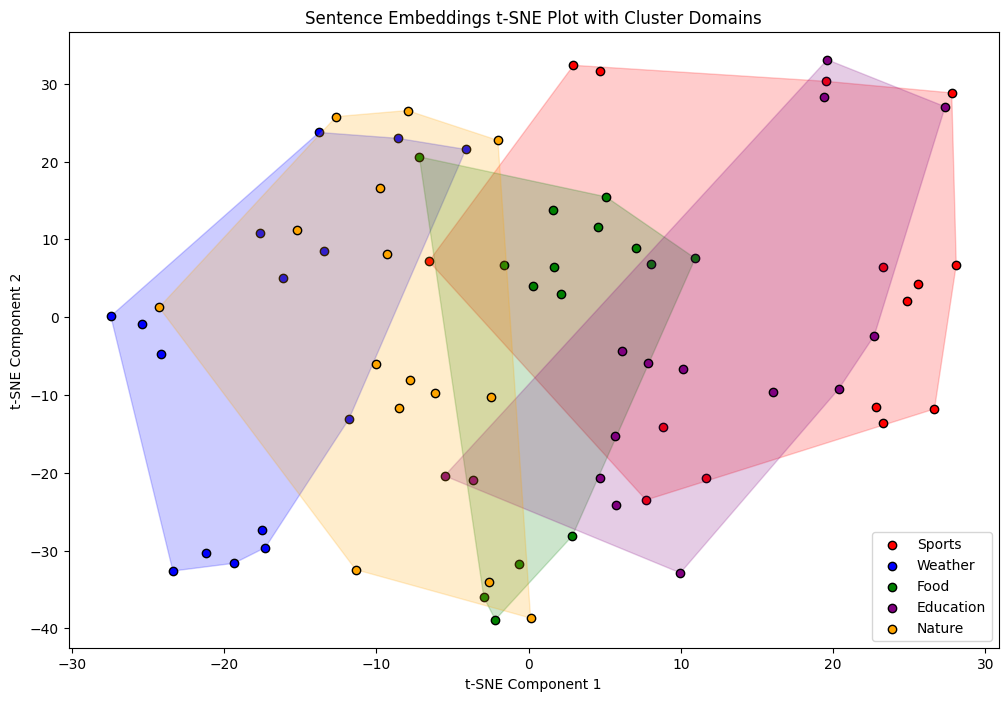

Domain Sizes (Areas of Convex Hulls):
Sports: 1412.0328
Weather: 726.8692
Food: 602.2097
Education: 980.3209
Nature: 1019.2807

The class with the largest domain area is: Sports

The class with the least domain area is: Food


In [46]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

# Updated list of sentences grouped by themes for better clustering
sentences = [
    # Sports
    "Anacheza mpira kila asubuhi.",
    "Timu yetu ilishinda mechi jana.",
    "Alifunga goli la ushindi.",
    "Ninapenda kushiriki mbio za masafa marefu.",
    "Kipa wetu alifanya magoli mengi kuokoa timu.",
    "Mashabiki walishangilia kwa sauti baada ya ushindi.",
    "Mchezaji huyo ana kasi na ujuzi mwingi.",
    "Nimesajiliwa kwenye klabu mpya ya soka.",
    "Mashindano ya riadha yatafanyika wiki ijayo.",
    "Tunajifunza michezo tofauti katika darasa la mazoezi.",
    "Kocha wetu anatuongoza kwenye mazoezi.",
    "Nilianguka wakati wa mchezo wa netiboli.",
    "Mchezo wa kikapu unahitaji urefu na ustadi.",
    "Tunaenda kuangalia mechi ya kriketi kesho.",
    "Nimejiandikisha kwa darasa la karate ili kujifunza kujilinda.",
    
    # Weather
    "Leo kuna mvua kubwa inanyesha.",
    "Kesho kutakuwa na jua kali.",
    "Hali ya hewa ni baridi sana asubuhi.",
    "Upepo mkali unavuma kutoka baharini.",
    "Joto la leo ni kali sana.",
    "Anga linatisha kwa sababu ya mawingu meusi.",
    "Kunyesha kwa mvua kumefanya barabara kuteleza.",
    "Theluji inanyesha kwenye mlima.",
    "Hali ya hewa imebadilika ghafla.",
    "Jua linachomoza upande wa mashariki kila asubuhi.",
    "Kuna ukame katika sehemu za kaskazini.",
    "Mvua ya mawe imeharibu mimea yetu.",
    "Utabiri wa hali ya hewa unasema kutakuwa na tufani.",
    "Unyevu hewa umeongezeka baada ya mvua.",
    "Kimbunga kinakaribia pwani yetu.",
    
    # Food
    "Mtoto alikula chakula kwa haraka.",
    "Napenda kupika wali na samaki.",
    "Chakula hiki kina ladha nzuri sana.",
    "Matunda haya ni matamu sana.",
    "Ninapenda kula ugali na nyama choma.",
    "Mama anapika supu ya mboga za majani.",
    "Mikate hii imeokwa vizuri.",
    "Anapenda kunywa chai na vitafunio.",
    "Tulipata chakula kizuri kwenye mgahawa mpya.",
    "Niliagiza sahani ya pilau na kachumbari.",
    "Tunavuna mahindi kutoka shambani.",
    "Juisi hii ya machungwa ni safi na tamu.",
    "Tafadhali ongeza chumvi kidogo kwenye chakula.",
    "Tunaenda sokoni kununua mboga na matunda.",
    "Anapenda kula chapati na maharage.",
    
    # Education
    "Mwanafunzi anaandaa masomo kwa bidii.",
    "Shule yetu imeshinda tuzo ya elimu bora.",
    "Ninapenda kusoma vitabu vya hadithi.",
    "Mtihani wa mwisho wa mwaka utafanyika mwezi ujao.",
    "Mwalimu wetu anafundisha hesabu vizuri sana.",
    "Tumeandaa mradi wa sayansi kwa ajili ya maonesho.",
    "Nataka kujiunga na chuo kikuu baada ya shule ya sekondari.",
    "Kitabu hiki cha historia kina taarifa muhimu.",
    "Tulifanya mazoezi mengi kabla ya mtihani.",
    "Elimu ni ufunguo wa maisha.",
    "Wanafunzi wanajifunza lugha mpya.",
    "Maktaba ina vitabu vingi vya kusoma.",
    "Tulipata matokeo mazuri katika somo la jiografia.",
    "Mkutano wa wazazi na walimu utafanyika kesho.",
    "Anafanya utafiti kuhusu mazingira.",
    
    # Nature
    "Mti huu una majani mazuri.",
    "Maji ya mto huu ni safi na baridi.",
    "Mbuga ya wanyama ina wanyama wengi wa porini.",
    "Milima mirefu inapendeza sana kuona.",
    "Kuna aina nyingi za ndege kwenye msitu huu.",
    "Jua linapozama, anga linakuwa na rangi nzuri.",
    "Tunapenda kutembea kwenye ufukwe wa bahari.",
    "Samaki wengi wanaishi baharini.",
    "Wanyama wa porini wanahitaji kuhifadhiwa.",
    "Miti inatoa hewa safi kwa ajili ya kupumua.",
    "Maua haya yana harufu nzuri.",
    "Kuna maporomoko ya maji kwenye mlima huu.",
    "Tunapanda miti ili kuhifadhi mazingira.",
    "Nyasi zimekuwa ndefu baada ya mvua.",
    "Nyuki huchavusha mimea kwa ajili ya uzalishaji."
]

# Tokenize the sentences
tokens = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to("cuda")

# Get embeddings from the model
with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)
    
    # Extract the last hidden states from the model
    last_hidden_state = outputs.hidden_states[-1]
    
    # Compute sentence embeddings by averaging the token embeddings across the sequence (dim=1)
    sentence_embeddings = last_hidden_state.mean(dim=1).cpu().numpy()  # Shape: (batch_size, hidden_size)

# Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42, n_iter=1000)
reduced_embeddings_tsne = tsne.fit_transform(sentence_embeddings)

# Create a list of themes (labels) for better visualization
labels = ['Sports'] * 15 + ['Weather'] * 15 + ['Food'] * 15 + ['Education'] * 15 + ['Nature'] * 15

# Create a color map for different themes (groups)
theme_colors = {
    'Sports': 'red',
    'Weather': 'blue',
    'Food': 'green',
    'Education': 'purple',
    'Nature': 'orange'
}

# Get colors corresponding to each label
colors = [theme_colors[label] for label in labels]

# Convert reduced embeddings to a NumPy array for indexing
reduced_embeddings_tsne = np.array(reduced_embeddings_tsne)

# Initialize a dictionary to store domain sizes
domain_sizes = {}

# Plot the t-SNE results with cluster domains
plt.figure(figsize=(12, 8))

# Unique labels
unique_labels = list(theme_colors.keys())

for label in unique_labels:
    # Get indices for the current label
    idx = [i for i, l in enumerate(labels) if l == label]
    # Get the corresponding points
    cluster_points = reduced_embeddings_tsne[idx]
    
    # Plot the convex hull
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        # Get the area of the convex hull
        area = hull.volume  # For 2D convex hulls, 'volume' returns the area
        domain_sizes[label] = area
        # Get the vertices of the convex hull
        hull_points = cluster_points[hull.vertices]
        # Create a polygon for the convex hull
        plt.fill(hull_points[:,0], hull_points[:,1], alpha=0.2, color=theme_colors[label])
    else:
        domain_sizes[label] = 0  # If not enough points, area is zero
    
    # Scatter plot for the points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=theme_colors[label], label=label, edgecolors='k')

# Avoid repeated labels in the legend
handles, current_labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(current_labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

# Set plot title and axis labels
plt.title("Sentence Embeddings t-SNE Plot with Cluster Domains")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Show the plot
plt.show()

# Output the sizes of the domains
print("Domain Sizes (Areas of Convex Hulls):")
for label, area in domain_sizes.items():
    print(f"{label}: {area:.4f}")

# Suggest the best class based on the largest domain
best_class = max(domain_sizes, key=domain_sizes.get)
print(f"\nThe class with the largest domain area is: {best_class}")

worst_class = min(domain_sizes, key=domain_sizes.get)
print(f"\nThe class with the least domain area is: {worst_class}")
